## Machine Learning Lecture 6.1

In [1]:
import sys
sys.path.append('/Users/tlee010/Desktop/github_repos/fastai/')

### Aside: Know how to sell - will always be a part of everyone's job : Be Noticed!

## Moving from Decision Trees to Deep Learning

There are some situations, were RF will not perform as well. For the kaggle grocery competition, its difficult to get a good score with RFC. This is due to :

- high cardinality
- time series
- lots of data

What about recognizing digits?

<img src="https://cdn-images-1.medium.com/max/1600/1*zY1qFB9aFfZz66YxxoI2aw.gif" alt="digit" style="width: 55%"/>
  

## 1. Get the Data

#### Load libraries

In [2]:
%load_ext autoreload
%autoreload 2

from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

#### Pull the saved data

In [3]:
URL='http://deeplearning.net/data/mnist/' 

In [4]:
!wget http://deeplearning.net/data/mnist/

--2017-11-21 14:49:53--  http://deeplearning.net/data/mnist/
Resolving deeplearning.net... 132.204.26.28
Connecting to deeplearning.net|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935 [text/html]
Saving to: ‘index.html.1’

index.html.1        100%[===================>]     935  --.-KB/s    in 0s      

2017-11-21 14:49:53 (89.2 MB/s) - ‘index.html.1’ saved [935/935]



In [5]:
path = './'

In [6]:
FILENAME='mnist.pkl.gz'
def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

#### Pickle - python object saving / loading

Great for saving python objects. You can save everything, but is not always optimal. You can save dictionaries, lists, complex objects. 

#### Feather - specific python dataframe saving / loading

Feather is specifically designed to save dataframes, to write and load fast

#### Deconstructing

If we know that a function will return a 2 item tuple, we can set a similar structure to capture the variables outside of the tuple as shown below.

```python
def myfunc:
    return (2,3)

(a,b) = myfunc

a = 2 # no longer tuple
b = 3 # no longer tuple
```

In [7]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

## 2. Data Normalization + Processing


### Image size: 28 x 28

We also notice that the dimensions are too high, this is because of the way that the data is stored. We will need to extract. 

#### Vocab:

#### Vector = 1d array = rank 1 tensor

#### Matrix = 2d array = rank 2 tensor

#### cube = 3d array = rank 3 tensor

If we take a look at the dimensions of the variables that we have loaded

In [8]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

**Does normalization matter for random forests for independent variables ?**  

No, When we normalize, we only care about the order. This is also why random forests are resilient to outliers.

**Does normalization matter for deep learning ?** 

Yes, because we are making a parameterized model.

#### Normalizing the entire dataset

In [9]:
mean = x.mean()
std = x.std()
x=(x-mean)/std
x.mean(), x.std()

(-3.1638146e-07, 0.99999934)

#### Normalize the Validation Set

Note that we are using the entire dataset mean and std to transform the validation set. This is to ensure standardized transformation between all datasets.

In [10]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.0058509219, 0.99243325)

### Helper Methods for Plotting

Wrapping the matplotlib library for showing images to make our lives a bit easier

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [12]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation='none', cmap='gray')

### Remember that all the data is stacked together, we will split into the individual images

In [13]:
x_valid.shape

(10000, 784)

**10,000 x 784 ** --> **10,000 x 28 x 28 **

**`(-1,28,28)`** - All neural networks, the first axis is a row, image, a sentence, example, then we reshape the last two axis 

In [14]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

### Example of a Reshape operation

![](http://ow7va355d.bkt.clouddn.com/shape.png)

<img src="http://www.scipy-lectures.org/_images/numpy_indexing.png" style='width:400px'/>

### Look at a image sample - first img

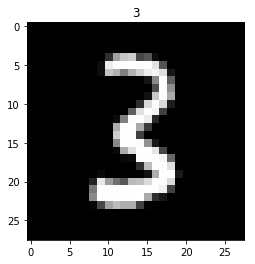

In [15]:
show(x_imgs[0], y_valid[0])

### Look at a labels - first label

In [16]:
y_valid.shape

(10000,)

In [17]:
y_valid[0]

3

### Look at part of an image (look at a portion of image #1)

Note we are using numpy's indexing to get to a portion of a matrix

<img src="https://www.safaribooksonline.com/library/view/python-for-data/9781449323592/httpatomoreillycomsourceoreillyimages1346882.png" style='width:300px' />

<img src="http://cfile9.uf.tistory.com/image/24037B3958B18FD907C784" style='width:500px' />

<img src="http://www.astroml.org/_images/fig_broadcast_visual_1.png" />

In [18]:
x_imgs[0,10:15,10:15]

array([[-0.42452, -0.42452, -0.42452, -0.42452,  0.17294],
       [-0.42452, -0.42452, -0.42452,  0.78312,  2.43567],
       [-0.42452, -0.27197,  1.20261,  2.77889,  2.80432],
       [-0.42452,  1.76194,  2.80432,  2.80432,  1.73651],
       [-0.42452,  2.20685,  2.80432,  2.80432,  0.40176]], dtype=float32)

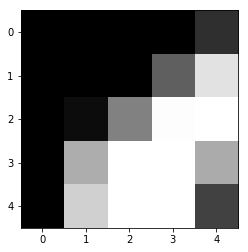

In [19]:
show(x_imgs[0,10:15,10:15])

### Preview some of the different classes of images

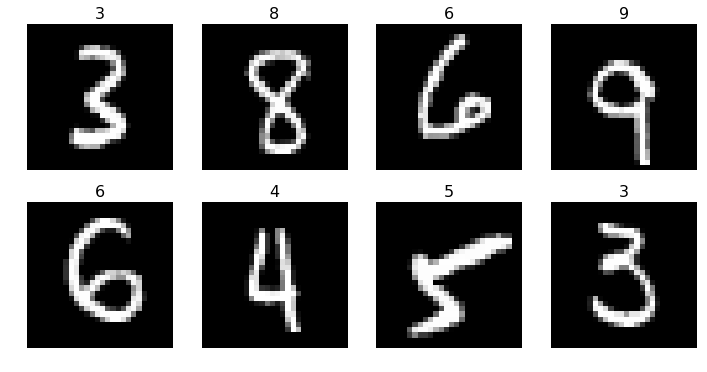

In [20]:
plots(x_imgs[:8], titles=y_valid[:8])

## Intro to Neural Network

Class of mathematical functions. Supports the universal approximation function. It can approximate anything, assuming we make it big enough.

### On Functions:

A **function** takes inputs and returns outputs. For instance, $f(x) = 3x + 5$ is an example of a function.  If we input $2$, the output is $3\times 2 + 5 = 11$, or if we input $-1$, the output is $3\times -1 + 5 = 2$

Functions have **parameters**. The above function $f$ is $ax + b$, with parameters a and b set to $a=3$ and $b=5$.

Machine learning is often about learning the best values for those parameters.  For instance, suppose we have the data points on the chart below.  What values should we choose for $a$ and $b$?

#### Animation (right image, fitting a function to the data):

<img src="https://cdn-images-1.medium.com/max/1600/1*KQVi812_aERFRolz_5G3rA.gif" />

### So what is a Neural-Net?

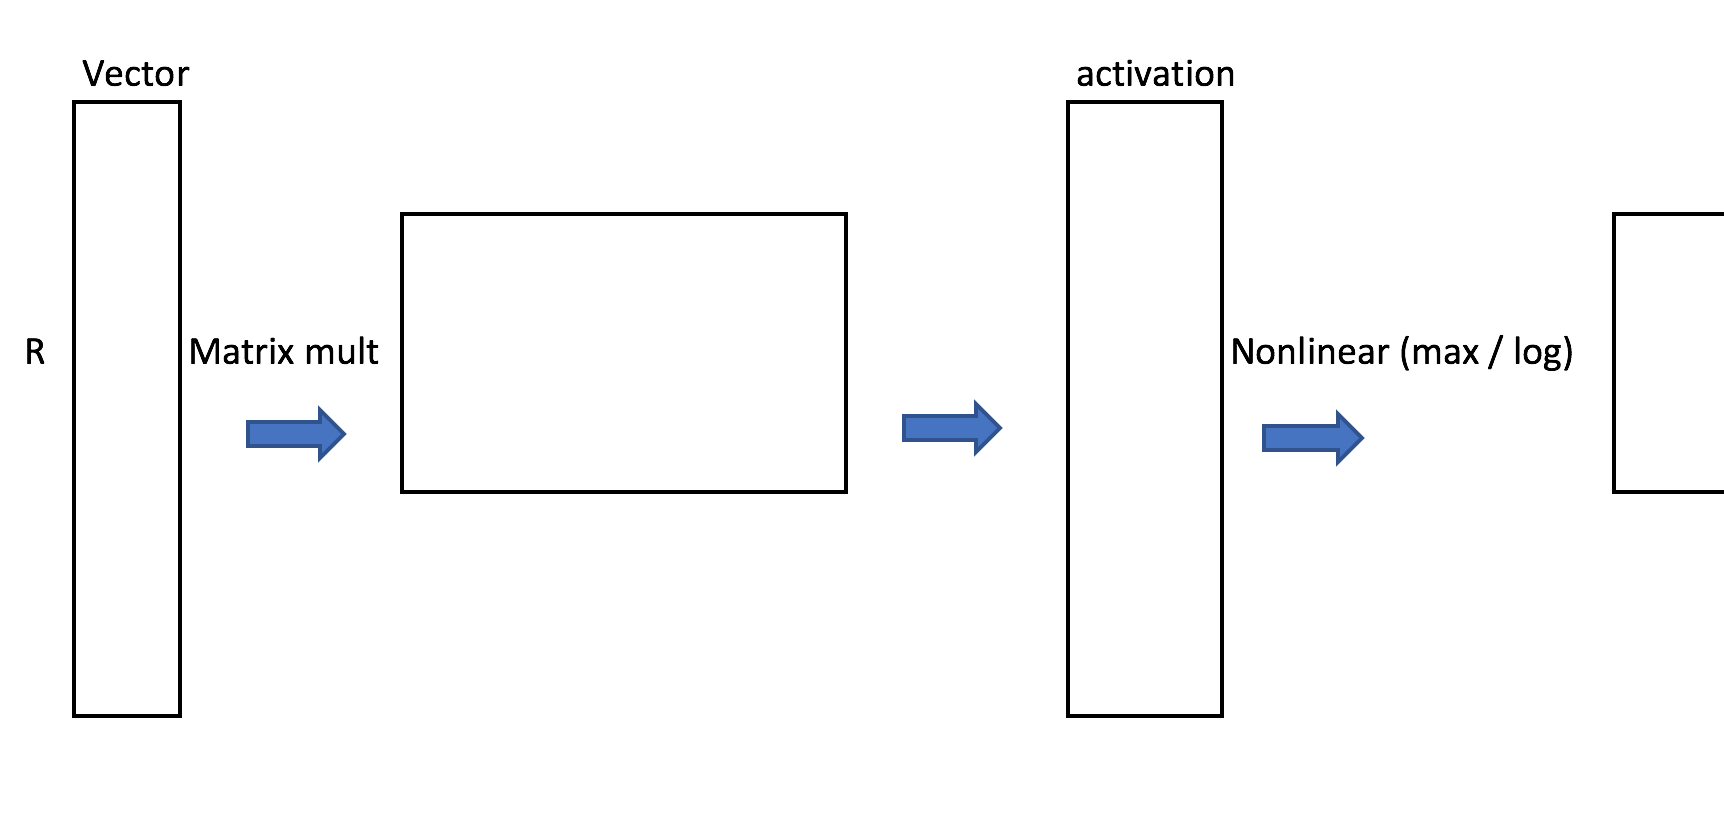

<img src ="https://www.researchgate.net/profile/Aleksandra_Vuckovic/publication/3978633/figure/fig2/AS:394699887136770@1471115194381/Fig-2-Feed-forward-neural-network-with-sigmoid-activation-function-X-i-i-1P-input.png" />

## Neural Networks with Pytorch

Graphical processing units (GPUs) allow for matrix computations to be done with much greater speed, as long as you have a library such as PyTorch that takes advantage of them.  Advances in GPU technology in the last 10-20 years have been a key part of why neural networks are proving so much more powerful now than they did a few decades ago. 

You may own a computer that has a GPU which can be used.  For the many people that either don't have a GPU (or have a GPU which can't be easily accessed by Python), there are a few differnt options:

- **Don't use a GPU**: For the sake of this tutorial, you don't have to use a GPU, although some computations will be slower.  The only change needed to the code is to remove `.cuda()` wherever it appears.


#### import libraries

In [21]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *
from fastai.core import *

import torch.nn as nn

#### Torch.nn Docs can be found here:

http://pytorch.org/docs/master/nn.html

#### Sequential PyTorchs

In [22]:
net = nn.Sequential(
    nn.Linear(28*28, 10),
    nn.LogSoftmax()
)#.cuda() #<--- signals to run on the GPU

**`nn.Linear(28*28, 10)`** - there are 28 x 28 images and output 10 size (for number classes). Linear layer, `y = ax + b` in a matrix format 

**` nn.LogSoftmax()`** - This is the non-linear layer. These can be converted to comparative probabilities.

In [23]:
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

**`ImageClassifierData`**  - wrapper for all the data

**`path`** - file path location 

**`(x,y)`** - training data

**`(x_valid, y_valid)`** - validation data


In [24]:
x.shape

(50000, 784)

In [25]:
loss=nn.NLLLoss()
metrics=[accuracy]
opt=optim.Adam(net.parameters())

**loss function** - this is our primary metric to determine how we are doing better. How do we score? (lower is better)

`nn.NLLLoss()` class torch.nn.NLLLoss(weight=None, size_average=True, ignore_index=-100, reduce=True)[source]
The negative log likelihood loss.



In [26]:
fit(net, md, epochs=1, crit=loss, opt=opt, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.31865  0.2866   0.91849]                         



### Sample of a Binary Loss functin

In [27]:
def binary_loss(y,p):
    return np.mean(-(y * np.log(p)+(1-y)*np.log(1-p)))

In [28]:
acts_sample = np.array([1, 0, 0, 1])
preds_sample = np.array([0.9, .1, .2, .8])
binary_loss(acts_sample, preds_sample)

0.164252033486018

##### We could replace this with a if statement  - see if you can scale it out to be a categorical cross entropy

### Prediction 10000 x 10

For each of the images in the validation set, we are making 10 predictions (probability for each of the numbers)

In [29]:
preds = predict(net, md.val_dl)

In [30]:
preds.shape

(10000, 10)

### Looking at single row

`argmax` returns the index of hte maximum value

In [31]:
preds[1]

array([-10.98194,  -7.74565,  -5.0269 ,  -4.07413,  -4.27588,  -3.71443,  -9.82602,  -9.61403,  -0.06536,
        -7.05641], dtype=float32)

In [32]:
preds.argmax(1)[:5]

array([3, 8, 6, 9, 6])

In [33]:
preds = preds.argmax(1)

In [34]:
np.sum(preds == y_valid)/len(preds)

0.91810000000000003

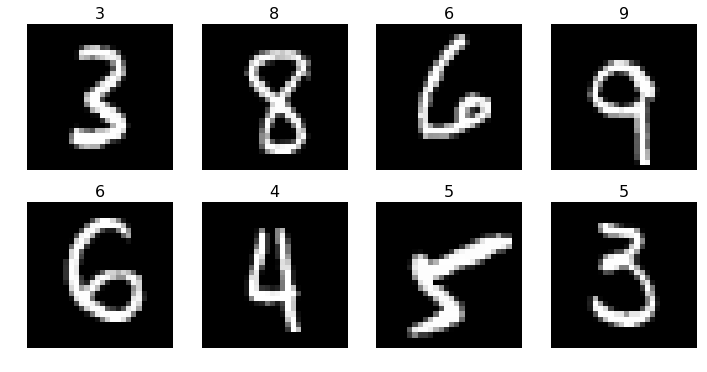

In [35]:
plots(x_imgs[:8], titles=preds[:8])

We see that the `4` is incorrect and the `3` is off. One of the reasons for this is not as accurate, is that we only have a single layer, and essentially making a **logistic regression.** A deep neural network will have many more layers.

    net = nn.Sequential(
        nn.Linear(28*28, 10), <--- input is multiplied
        nn.LogSoftmax()       <--- then logistic regression is applied
    )#.cuda()



## Let's Define Logistic Regression

Will do this by defining a pytorch class

In [39]:
torch.randn(3,4) # <-- similar to numpy language


 1.9552 -0.5213  0.3728  0.8425
-0.8652 -0.7114  0.4367 -0.0971
-1.0709 -0.0252  0.8083 -0.1447
[torch.FloatTensor of size 3x4]

In [42]:
torch.randn(3,4).cuda() # <-- similar to numpy language, but with GPU!


-0.3837 -0.9107  0.7963 -2.0376
 0.8746  1.1661  0.9240  0.1158
-1.3293  1.9849 -0.8541  0.0062
[torch.FloatTensor of size 3x4]

In [37]:
def get_weights(*dims): return nn.Parameter(torch.randn(*dims)/dims[0])

Initializing the random weights, that are nicely behaved. Mean =0, standard deviation = 1. 

### Basic Logistic Regression pytorch class (not a layer / nn architecture)

In [44]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.matmul(x, self.l1_w) + self.l1_b  # Linear Layer
        x = torch.log(torch.exp(x)/(1 + torch.exp(x).sum(dim=0)))        # Non-linear (LogSoftmax) Layer
        return x

**`(nn.module)`** <-- we are ***extending*** a pytorch class. we are borrowing all the methods from the standard module and will add some additional methods to it.

**`super().__init__()`** <-- as a result, we have to create or instantiate the standard module first

**`self.l1_w = get_weights(28*28, 10) `** is essentially the `ax` part of `y=ax + b`

**`self.l1_b = get_weights(10) `** is essentially the `b` part of `y=ax + b`


#### Pytorch special method: forward

**`forward`** - special hook in the pytorch library, how we are implementing each layer 

http://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#forward-and-backward-function-hooks

You can register a function on a `Module` or a `Variable`. The hook can be a forward hook or a backward hook. The forward hook will be executed when a forward call is executed. The backward hook will be executed in the backward phase. Let’s look at an example.
 

**`x = x.view(x.size(0), -1)`** - is the reshape (flatten)

**`x = torch.matmul(x, self.l1_w) + self.l1_b`** - matrix multiplication 

**`x = torch.log(torch.exp(x)/(1 + torch.exp(x).sum(dim=0)))`** - softmax from scratch

### How the matrix multiplication works out (screenshot):

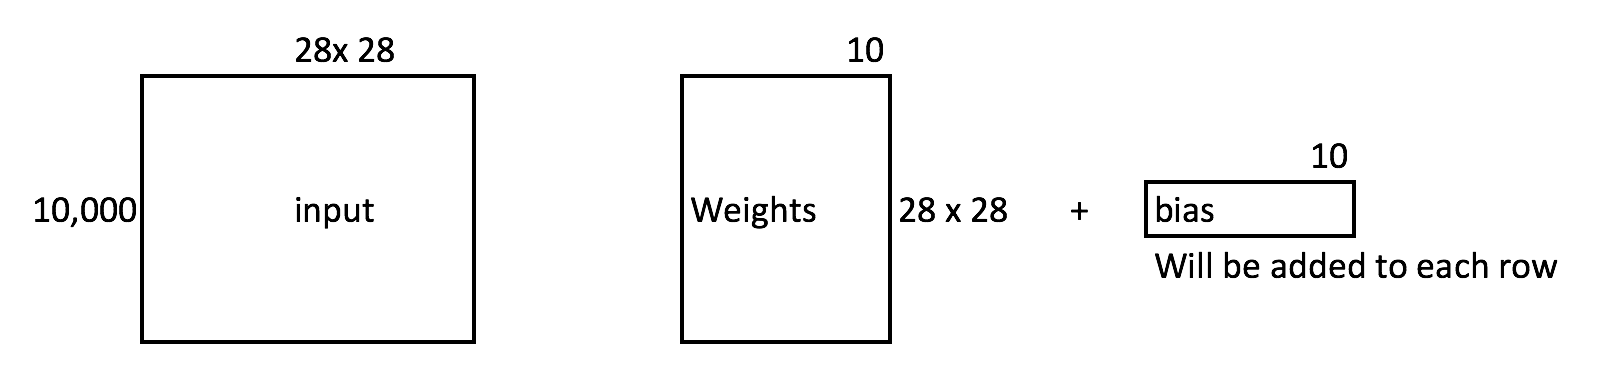

In [45]:
net2 = LogReg()#.cuda()
opt=optim.Adam(net2.parameters())

In [46]:
fit(net2, md, epochs=1, crit=loss, opt=opt, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       2.43236  2.39509  0.90993]                        



In [47]:
np.sum(preds == y_valid)/len(preds)

0.91810000000000003

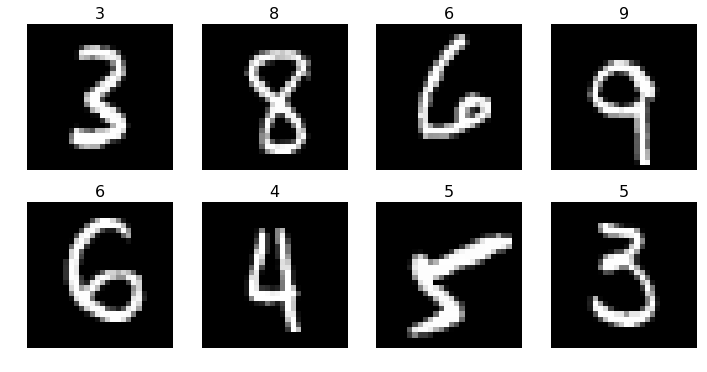

In [48]:
preds = predict(net2, md.val_dl).argmax(1)
plots(x_imgs[:8], titles=preds[:8])

### To dos:

Play with pytorch tutorials, 

- matrix multiplication
- play with tensors
- play with pytorch and functions